In [9]:
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import astropy
import astropy.stats
from astropy.stats import binom_conf_interval
from astropy.table import Table
from os import listdir
from os.path import isfile, join
import math
import scipy
from scipy import stats

In [2]:
predfiles = [f for f in listdir('MPhys/catalogues/base_filter_permutations/PRED') if isfile(join('MPhys/catalogues/base_filter_permutations/PRED', f))]
trainfiles = [f for f in listdir('MPhys/catalogues/base_filter_permutations/TRAIN') if isfile(join('MPhys/catalogues/base_filter_permutations/TRAIN', f))]

In [63]:
predfiles.sort()
trainfiles.sort()
predfiles[7]

'PRED_filter_choice_f200w_to_f210m.cat'

In [66]:
for i in trainfiles:
    x = [i.split('_')[5]for i in trainfiles]
for j in x:
    filt = [j.split('.')[0]for j in x]

change_filt = 'f444w'

# Redshift Plotting 


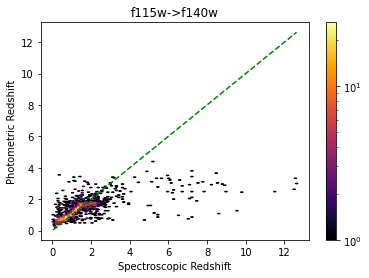

In [18]:

for i in range(1,2):

    zspec_lst =[]
    zphot = []
    error=[]
    file_zspec = open(f'MPhys/catalogues/base_filter_permutations/PRED/{predfiles[i]}','r')
    #file_zspec['VALUE']
    for _ in range(1):
        next(file_zspec)
    for line in file_zspec:
        #print(len(line))
        splitter = re.sub("\s+",",",line.strip())
        tokens = splitter.split(',')

        zspec_lst.append(float(tokens[4]))
    file_zspec.close()

    file = open(f'MPhys/gpz_files/gpz_jwst_{change_filt}-{filt[i]}.cat','r')
    for _ in range(11):
        next(file)
    for line in file:
        splitter_numbf = re.sub("\s+",",",line.strip())
        tokens_numbf = splitter_numbf.split(',')
        zphot.append(float(tokens_numbf[1]))
        error.append(float(tokens_numbf[0]))
    file.close()
    x = np.linspace(np.min(zspec_lst),np.max(zspec_lst))

    plt.plot(x,x,color = 'g',linestyle = '--')
    plt.hexbin(zspec_lst, zphot,cmap = 'inferno',bins='log',mincnt=1)
    plt.xlabel('Spectroscopic Redshift')
    plt.ylabel('Photometric Redshift')
    #plt.xlim(0,8)
    #plt.ylim(0,8)
    plt.title(f'{change_filt}->{filt[i]}')

    plt.colorbar()
    plt.savefig(f'MPhys/gpz_files/{change_filt}_to_{filt[i]}_hexplot.png')
    plt.show()
    plt.close()


# Statistics 


In [67]:
zspec_stat =[]
zphot_stat = []
error_stat=[]
x=[]

p=0
l= np.arange(0,1.2,0.1)

sigs=[]
olfs=[]
olfs_sig=[]
olfs_err_l=[]
olfs_err_u=[]
olfs_err_sig_l=[]

olfs_err_sig_u=[]
w=8

file= open(f'MPhys/catalogues/base_filter_permutations/PRED/{predfiles[w]}','r')
#file_zspec['VALUE']
for _ in range(1):
    next(file)
for line in file:
    #print(len(line))
    splitter = re.sub("\s+",",",line.strip())
    tokens = splitter.split(',')

    zspec_stat.append(float(tokens[4]))
file.close()

file = open(f'MPhys/gpz_files/gpz_jwst_{change_filt}-{filt[w]}.cat','r')
for _ in range(11):
    next(file)
for line in file:
    splitter_numbf = re.sub("\s+",",",line.strip())
    tokens_numbf = splitter_numbf.split(',')
    zphot_stat.append(float(tokens_numbf[1]))
    error_stat.append(float(tokens_numbf[2]))
file.close()

delta_z = []
outliers = []

logz = []
for i in range(len(zphot_stat)):
    delta_z.append(abs(float(zphot_stat[i])-float(zspec_stat[i])))
    outliers.append(float(delta_z[i])/(1+float(zspec_stat[i])))
    logz.append(np.log10(1+zspec_stat[i]))

###

file = open(f'MPhys/redshift_binned_olf_{filt[w]}.txt','w+')
file.write('redshift bin, olf, olf_err_lower, olf_err_upper, olf_3sig, olf_3sig_err_lower, lf_3sig_err_upper, sig_nmad \n')
while p<len(l):
    m=0
    k=0
    c=0
    for j in range(len(logz)):

        if l[p]<=logz[j]<=l[p]+0.1:
            c+=1
            x.append(delta_z[j]/(1+float(zspec_stat[j])))
    sig_nmad = scipy.stats.median_abs_deviation(x)
    for j in range(len(logz)):
        if l[p]<=logz[j]<=l[p]+0.1:



            if abs(outliers[j])>0.15:
                m+=1
            if abs(outliers[j])>(3*sig_nmad):
                k+=1


    outlier_frac = m/c
    err= binom_conf_interval(outlier_frac,c)
    outlier_frac_sig =k/c
    err_three_sig= binom_conf_interval(outlier_frac_sig,c)
    print(err[0])

    file.write(str(l[p])+','+str(outlier_frac)+','+str(err[0])+','+str(err[1])+','+str(outlier_frac_sig)+','+str(err_three_sig[0])+','+str(err_three_sig[1])+','+str( sig_nmad)+'\n')
    p+=1
file.close()

#####


file = open(f'MPhys/redshift_binned_olf_{filt[w]}.txt','r')
for _ in range(1):
    next(file)
for line in file:

    splitter = re.sub("\s+",",",line.strip())
    tokens = splitter.split(',')

    sigs.append(float(tokens[7]))

    olfs.append(float(tokens[1]))
    olfs_err_l.append(float(tokens[2]))
    olfs_err_u.append(float(tokens[3]))

    olfs_sig.append(float(tokens[4]))
    olfs_err_sig_l.append(float(tokens[5]))
    olfs_err_sig_u.append(float(tokens[6]))
file.close()
####
x_vals = l+0.05
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].errorbar(x_vals,sigs,marker = 'o',ls='none',color='navy')

ax[1].errorbar(x_vals, olfs,yerr = (olfs_err_u,olfs_err_l),marker = 'o',color= 'orange',label = '$OLF_{0.15}$',ls='none')
ax[1].errorbar(x_vals, olfs_sig,yerr=(olfs_err_sig_u,olfs_err_sig_l),marker = 'o',color= 'darkgreen',ls='none',label ='$OLF_{>3\sigma}$' )
ax[0].set_ylabel('$\sigma_{NMAD}$')
ax[1].set_ylabel('OLF')
ax[1].set_xlabel('$log_{10}(1+z_{spec})$')
ax[0].set_title(f'{filt[0]} replacing {change_filt}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'MPhys/plots/OLF_{filt[w]}_replace_{change_filt}.png',bbox_inches='tight')
plt.close()
    
   # w+=1


1.734723475976807e-18
2.168404344971009e-19
0.0
0.0
0.0
0.0
0.0
0.032298165807384344
0.01673257451063867
0.015384600933071854
0.048815490527932826
0.13564309455027307


1


In [17]:
x=[]

p=0
l= np.arange(0,1.2,0.1)
file = open(f'MPhys/redshift_binned_olf_{filt[1]}.txt','w+')
file.write('redshift bin, olf, olf_err_lower, olf_err_upper, olf_3sig, olf_3sig_err_lower, lf_3sig_err_upper, sig_nmad \n')
while p<len(l):
    m=0
    k=0
    c=0
    for j in range(len(logz)):
        
        if l[p]<=logz[j]<=l[p]+0.1:
            c+=1
            x.append(delta_z[j]/(1+float(zspec_stat[j])))
    sig_nmad = scipy.stats.median_abs_deviation(x)
    for j in range(len(logz)):
        if l[p]<=logz[j]<=l[p]+0.1:
            


            if abs(outliers[j])>0.15:
                m+=1
            if abs(outliers[j])>(3*sig_nmad):
                k+=1
            
    
    outlier_frac = m/c
    err= binom_conf_interval(outlier_frac,c)
    outlier_frac_sig =k/c
    err_three_sig= binom_conf_interval(outlier_frac_sig,c)
    print(err[0])
    
    file.write(str(l[p])+','+str(outlier_frac)+','+str(err[0])+','+str(err[1])+','+str(outlier_frac_sig)+','+str(err_three_sig[0])+','+str(err_three_sig[1])+','+str( sig_nmad)+'\n')
    p+=1
file.close()




1.734723475976807e-18
0.0
0.0
1.0842021724855044e-19
0.0
4.336808689942018e-19
0.0
0.0
0.02269940574337577
0.02028781544751749
0.13564309455027307
0.13564309455027307


10
0.7000000000000001 1.0 0.11635192650064519


In [20]:
sigs=[]
olfs=[]
olfs_sig=[]
olfs_err_l=[]
olfs_err_u=[]
olfs_err_sig_l=[]

olfs_err_sig_u=[]
file = open(f'MPhys/redshift_binned_olf_{filt[1]}.txt','r')
for _ in range(1):
    next(file)
for line in file:

    splitter = re.sub("\s+",",",line.strip())
    tokens = splitter.split(',')
    
    sigs.append(float(tokens[7]))
    
    olfs.append(float(tokens[1]))
    olfs_err_l.append(float(tokens[2]))
    olfs_err_u.append(float(tokens[3]))
    
    olfs_sig.append(float(tokens[4]))
    olfs_err_sig_l.append(float(tokens[5]))
    olfs_err_sig_u.append(float(tokens[6]))
   

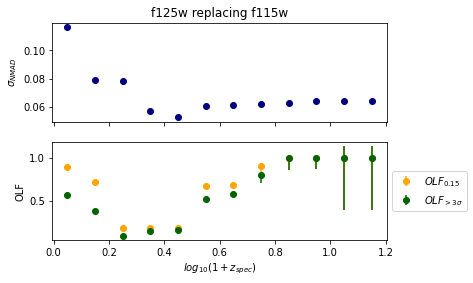

In [36]:
x_vals = l+0.05
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].errorbar(x_vals,sigs,marker = 'o',ls='none',color='navy')

ax[1].errorbar(x_vals, olfs,yerr = (olfs_err_u,olfs_err_l),marker = 'o',color= 'orange',label = '$OLF_{0.15}$',ls='none')
ax[1].errorbar(x_vals, olfs_sig,yerr=(olfs_err_sig_u,olfs_err_sig_l),marker = 'o',color= 'darkgreen',ls='none',label ='$OLF_{>3\sigma}$' )
ax[0].set_ylabel('$\sigma_{NMAD}$')
ax[1].set_ylabel('OLF')
ax[1].set_xlabel('$log_{10}(1+z_{spec})$')
ax[0].set_title(f'{filt[0]} replacing {change_filt}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'MPhys/plots/OLF_{filt[1]}_replace_{change_filt}.png')

# Comparison of Different Parameters


In [52]:
##difference between diagonal and full covarience
zphot_full = []
error_full=[]

file = open(f'MPhys/parameter_files/gpz_GPGC.cat','r')
for _ in range(11):
    next(file)
for line in file:

    splitter_numbf = re.sub("\s+",",",line.strip())
    tokens_numbf = splitter_numbf.split(',')
    
    zphot_full.append(float(tokens_numbf[0]))
    error_full.append(float(tokens_numbf[1])/float(1+float(tokens[10])))

file.close()

In [53]:
##difference between diagonal and full covarience
zphot_diag = []
error_diag=[]

file = open(f'MPhys/parameter_files/gpz_nbf150.cat','r')
for _ in range(11):
    next(file)
for line in file:

    splitter_numbf = re.sub("\s+",",",line.strip())
    tokens_numbf = splitter_numbf.split(',')
    
    zphot_diag.append(float(tokens_numbf[0]))
    
    error_diag.append(float(tokens_numbf[1])/float(1+float(tokens[10])))

file.close()


In [54]:
highdiff=[]
diff=[]
tst=[]
a=[]
for i in range(len(zphot_diag)):
    diff.append(abs(zphot_diag[i]-zphot_full[i]))
    #print((zphot_full[i]/100)*2)
for j in range(len(diff)):
    #tst.append((zphot_diag[j]*0.02))
    if diff[j]>=((1+zphot_diag[j])*0.2):
        if diff[j]>0:
            highdiff.append(j)


In [55]:
new_gpvd=[]
new_gpvd_err=[]
new_gpvc=[]
new_gpvc_err=[]
new_zspec=[]
for k in highdiff:
    if k>0:
        new_gpvd.append(zphot_diag[k])
        new_gpvd_err.append(error_diag[k])
        
        new_gpvc.append(zphot_full[k])
        new_gpvc_err.append(error_full[k])
        new_zspec.append(zspec[k])
        
        
new_data_diag = np.array((new_gpvd,new_zspec,new_gpvd_err ))
new_data_full = np.array((new_gpvc,new_zspec,new_gpvc_err ))


2869


In [47]:
print(new_gpvd[0],new_zspec[0])
fig,ax= plt.subplots(1,3,sharex=True,sharey=True,figsize=(10, 4))
ax[0].hexbin(new_data_full[0] , new_data_diag[1],cmap = 'autumn',bins='log')
ax[1].hexbin(new_data_diag[0] , new_data_diag[1],cmap='winter',bins='log')
ax[2].hexbin(new_data_diag[0] , new_data_diag[1],cmap='winter',bins='log')
ax[2].hexbin(new_data_full[0] , new_data_diag[1],cmap = 'autumn',bins='log')
#plt.hexbin(new_data_full[0] , new_data_diag[1],bins='log')
ax[0].set_title('Full \n Covariance')
ax[1].set_title('Diagonal \n Covariance')
ax[2].set_title('Full and Diagonal \n Covariance')


fig.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig('MPhys/diag_full_cov_difference_10pc.png')
plt.close()

0.1556116 0.12077


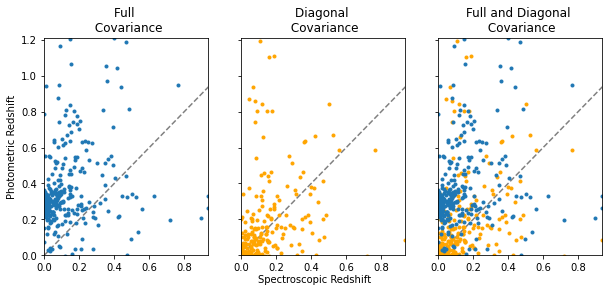

In [63]:
x=np.linspace(0,np.max(new_data_full[0]),20)

fig,ax= plt.subplots(1,3,sharex=True,sharey=True,figsize=(10, 4))
fig.text(0.5, 0.04, 'Spectroscopic Redshift', ha='center', va='center')
#a.set_xlabel('Spectroscopic Redshift')
ax[0].set_ylabel('Photometric Redshift')
ax[0].errorbar(new_data_full[1] , new_data_full[0],fmt='.')#,cmap = 'autumn',bins='log')
ax[1].errorbar(new_data_diag[1] , new_data_diag[0],color = 'orange',fmt='.')#,cmap='winter',bins='log')
ax[2].errorbar(new_data_diag[1] , new_data_diag[0],color = 'orange',fmt='.')#,cmap='winter',bins='log')
ax[2].errorbar(new_data_full[1] , new_data_full[0],fmt='.')#,cmap = 'autumn',bins='log')
#plt.hexbin(new_data_full[0] , new_data_diag[1],bins='log')
ax[0].plot(x,x,linestyle = '--', color = 'grey')
ax[1].plot(x,x,linestyle = '--', color = 'grey')
ax[2].plot(x,x,linestyle = '--', color = 'grey')
ax[0].set_title('Full \n Covariance')
ax[1].set_title('Diagonal \n Covariance')
ax[2].set_title('Full and Diagonal \n Covariance')

plt.xlim(0,np.max(new_data_full[1]))
plt.ylim(0,np.max(new_data_full[0]))
plt.savefig('MPhys/parameter_plots/full_vs_diag.png')

(0.0, 1.2)

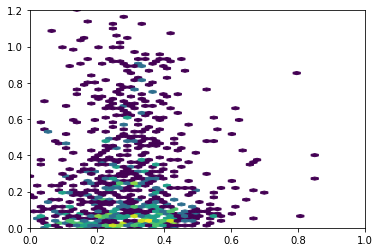

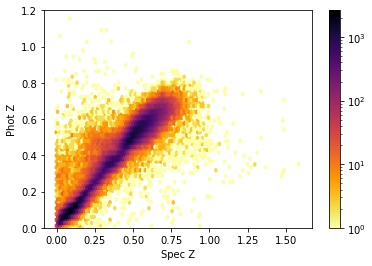